In [23]:
!pip3 install nufeb-tools -U --quiet

Traceback (most recent call last):
  File "C:\Users\Jonathan\anaconda3\envs\nufeb\Scripts\pip3-script.py", line 6, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip._internal.cli.main'


In [3]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
#from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error 
from skopt import dump, load
from skopt.callbacks import CheckpointSaver
import seaborn as sns

In [4]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)

In [5]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    """Recompile NUFEB with new fitting parameters

    Args:
        alpha ([type]): [description]
        tau ([type]): [description]
        c ([type]): [description]
        alpha2 ([type]): [description]
        tau2 ([type]): [description]
        c2 ([type]): [description]
    """
    #
    filein = open( f'/mnt/home/sakkosjo/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
                                        
                                        })
    with open("/mnt/home/sakkosjo/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    os.chdir('/mnt/home/sakkosjo/NUFEB/')
    os.system('module load libpng; ./install.sh --enable-hdf5')

def func(x):
    """Optimization function

    Args:
        x ([type]): [description]

    Returns:
        [type]: RMSE
    """
    global Nfeval
    #OD750 fitting
    alpha = x[0]
    tau = x[1]
    c = x[2]
    #Sucrose fitting
    alpha2 = x[3]
    tau2 = x[4]
    c2 = x[5]
    #growth rate
  

    #Change input params
    
    recompile(alpha,tau,c,alpha2,tau2,c2)
    print(f'alpha: {alpha},tau: {tau},c: {c},alpha2: {alpha2},tau2: {tau2},c2: {c2}')

    #Clean old simulations
    os.chdir('/mnt/gs18/scratch/users/sakkosjo')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 5 --cells 10,0 --t 8700 --mucya 1.89e-5 --iptg {iptg}'
        os.system(text)
    #Run new simulations
    os.system('sbatch /mnt/home/sakkosjo/nufeb-cyano-e-coli/scripts/nufeb-parallel.sbatch')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = np.prod(data[0].metadata['Dimensions'])
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['IPTG']
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)
    df.reset_index(inplace=True)
    #save in progress plot
    f, ax = plt.subplots(ncols=2)
    ax[0].set_title('Sucrose')
    ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')

    sns.lineplot(x='IPTG',y='Sucrose',ax=ax[0],data=df)
    ax[1].set_title('OD750')
    ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
    sns.lineplot(x='IPTG',y='OD750',ax=ax[1],data=df)
    f.tight_layout()
    f.savefig(f'/mnt/home/sakkosjo/nufeb-cyano-e-coli/simulation-data/se-opt-{Nfeval}.png')
    plt.close()
    #Compare output with experimental data via RMSE

    Nfeval += 1
    ODerr=0
    SUCerr=0
    temp = df.groupby('IPTG').mean().reset_index()
    if len(temp.OD750)==len(test_data.OD750):
        ODerr = np.average((test_data.OD750 - temp.OD750) ** 2, axis=0, weights=test_data.OD750)+ODerr
    else:
        ODerr = (((temp.OD750-test_data.OD750)/test_data.OD750)**2).mean()+ODerr

    if len(temp.Sucrose)==len(test_data.Sucrose):
        SUCerr = np.average((test_data.Sucrose - temp.Sucrose) ** 2, axis=0, weights=test_data.Sucrose)+SUCerr
    else:
        SUCerr = (((temp.Sucrose-test_data.Sucrose)/test_data.Sucrose)**2).mean()+SUCerr
    return ODerr + SUCerr

# Growth curve fitting

In [6]:
res = load('../checkpoints/checkpoint-se-icer.pkl')
x0 = res.x_iters
y0 = res.func_vals
          #  x0=x0,              # already examined values for x
       #     y0=y0,              # observed values for x0

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

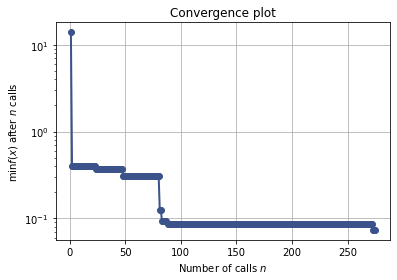

In [7]:
plot_convergence(res,yscale='log')

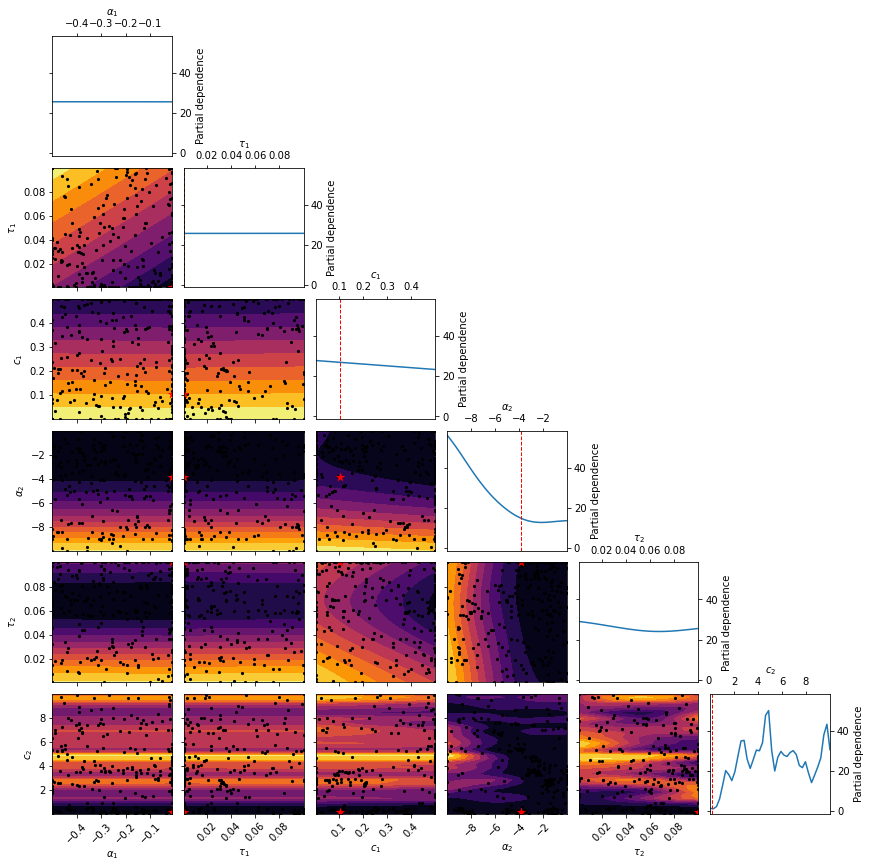

In [12]:
axes = plot_objective(res,dimensions=[r'$\alpha_1$',r'$\tau_1$',r'$c_1$',r'$\alpha_2$',r'$\tau_2$',r'$c_2$'],cmap='inferno')
#axes.flatten()[0].figure.savefig("../figures/se-objective.png")

In [11]:
res.x

[-0.010000000000000009,
 0.001,
 0.10448819424304515,
 -3.8679493046525844,
 0.1,
 0.12680437402828154]

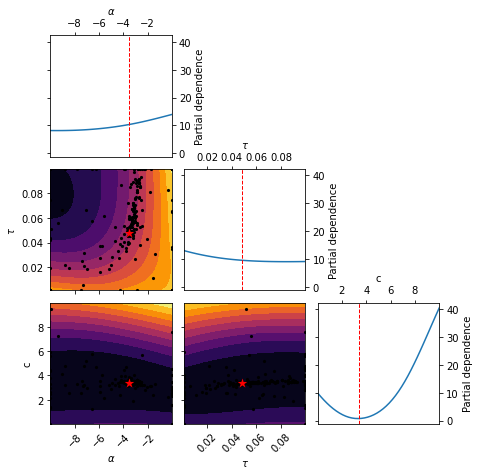

In [34]:
axes = plot_objective(res,dimensions=[r'$\alpha$',r'$\tau$','c'],cmap='inferno')
#axes.flatten()[0].figure.savefig("../figures/se-objective.png")

In [35]:
res.x

[-3.4897341206041004, 0.048054721764639076, 3.4091902801428087]